# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Load Data

In [3]:
# Folder containing the datset
data_dir = 'dataset/processed_data'

In [4]:
def load_data(filename, data_dir, data_type):
    h5f = h5py.File(os.path.join(data_dir, filename), 'r')
    data = h5f[data_type][:]
    h5f.close()
    return data

Load training data

In [49]:
train_images = load_data('train_images.h5', data_dir, 'images')

In [50]:
train_categories = load_data('train_categories.h5', data_dir, 'labels')

Load validation data

In [39]:
val_images = load_data('val_images.h5', data_dir, 'images')

In [40]:
val_categories = load_data('val_categories.h5', data_dir, 'labels')

Load test data

In [5]:
test_images = load_data('test_images.h5', data_dir, 'images')

In [6]:
test_categories = load_data('test_categories.h5', data_dir, 'labels')

Load mapping

In [7]:
with open('dataset/coco_raw.pickle', 'rb') as file:
    coco_raw = pickle.load(file)
id_category = coco_raw['id_category']

In [8]:
num_classes = len(id_category)
num_classes

80

In [ ]:
num_images_train = train_images.shape[0]
num_images_train

### Display a sample image

In [ ]:
# display image
idx = 10

for category, value in enumerate(train_categories[idx]):
    if value != 0:
        print(id_category[category])

plt.imshow(train_images[idx])
plt.show()

# Define Model

In [11]:
# Download VGG19 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# Extract the last layer from the last convolutional block
conv_layer = model.get_layer('block5_pool')

In [13]:
conv_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [14]:
# Create model
conv_model = Model(inputs=model.input, outputs=conv_layer.output)

In [15]:
# Start a new Keras Sequential model
image_model = Sequential()

# Add the convolutional part of the VGG19 model
image_model.add(conv_model)

# Flatten the output of the VGG19 model because it is from a
# convolutional layer
image_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG19 model has
# recognized in the image.
image_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
# image_model.add(Dropout(0.5))

# Add the final layer for the actual classification
image_model.add(Dense(num_classes, activation='sigmoid'))

In [16]:
# Set the VGG19 layers to be non-trainable
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [17]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 80)                82000     
Total params: 45,797,520
Trainable params: 25,773,136
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
# Compile the model
optimizer = Adam(lr=1e-3)

image_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [20]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

path_checkpoint = os.path.join(weights_dir, 'checkpoint.keras')

# set model callbacks
tb = TensorBoard(log_dir=os.path.join(weights_dir, 'tensorboard-logs'), histogram_freq=0, write_graph=False)
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks = [tb, checkpoint, early_stop]

# Train Model

In [21]:
# Load previously trained model weights
try:
    image_model.load_weights(path_checkpoint)
    print('Checkpoint loaded.')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Loaded checkpoint


In [ ]:
image_model.fit(
    x=train_images,
    y=train_categories,
    batch_size=128,
    epochs=100,
    callbacks=callbacks,
    validation_data=(val_images, val_categories)
)

# Test Model

In [55]:
def get_predictions(image, label, id_category):
    image_batch = np.expand_dims(image, axis=0)
    predictions = image_model.predict(image_batch)
    
    prediction_labels = []
    for index, prediction_probability in enumerate(predictions[0]):
        if prediction_probability > 0.5:
            prediction_labels.append(id_category[index])
    
    true_labels = []
    for index, value in enumerate(label):
        if value == 1:
            true_labels.append(id_category[index])
    
    print('True labels:', true_labels)
    print('Predictions:', prediction_labels)
    
    print('Image:')
    plt.imshow(image)
    plt.show()

True labels: ['person', 'bicycle', 'skateboard']
Predictions: ['person', 'skateboard']
Image:


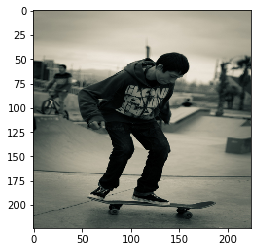

In [59]:
idx = 18
get_predictions(test_images[idx], test_categories[idx], id_category)